# Inference Time Baby 😎

In [1]:
from pathlib import Path
from types import SimpleNamespace

import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'gray_r'

import wandb

## Grab the Dataset

In [2]:
with wandb.init(project="ddpm_clouds"):
    artifact = wandb.use_artifact('capecape/gtc/np_dataset:v0', type='dataset')
    dataset_dir = Path(artifact.download())

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: capecape. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact np_dataset:v0, 3816.62MB. 30 files... 
wandb:   30 of 30 files downloaded.  
Done. 0:0:0.0


## Grab the trained Model

In [3]:
with wandb.init(project="ddpm_clouds"):
    artifact = wandb.use_artifact('capecape/ddpm_clouds/xq6vlibx_ddpm_clouds:v0', type='model')
    model_dir = Path(artifact.download())

wandb: Downloading large artifact xq6vlibx_ddpm_clouds:v0, 60.77MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.0


## everything together

In [4]:
config = SimpleNamespace(    
    epochs = 100,
    model_name="ddpm_clouds",
    noise_steps=1000,
    seed = 42,
    batch_size = 64,
    img_size = 64,
    device = "cuda",
    use_wandb = True,
    num_workers=8,
    num_frames=3,
    lr = 5e-4)

In [5]:
import torch
from fastprogress import progress_bar
from diffusers import UNet2DModel

from clouds import CloudDataset, ls

from torch_moving_mnist.utils import *

In [6]:
files = ls(Path(dataset_dir))
valid_ds = CloudDataset(files[-3:], valid=True)

In [7]:
model = UNet2DModel(in_channels=4, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)

load checkpoint

In [8]:
from pathlib import Path
ls(Path(model_dir))

[PosixPath('artifacts/xq6vlibx_ddpm_clouds:v0/ddpm_clouds.pth')]

In [9]:
model.load_state_dict(torch.load('artifacts/xq6vlibx_ddpm_clouds:v0/ddpm_clouds.pth'))

<All keys matched successfully>

In [10]:
model = model.to(config.device)

## Sampling

In [11]:
betamin,betamax,n_steps = 0.0001,0.02,config.noise_steps
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

In [13]:
@torch.no_grad()
def sample(model, xt):
    "Slightly different than the one used during training, takes only a lenght 3 tensor)"
    device = next(model.parameters()).device
    past_frames = xt
    new_frame = torch.randn_like(xt[:,-1:], dtype=xt.dtype, device=device)
    preds = []
    for t in progress_bar(reversed(range(n_steps)), total=n_steps, leave=False):
        t_batch = torch.full((new_frame.shape[0],), t, device=device, dtype=torch.long)
        z = torch.randn(new_frame.shape, device=device) if t > 0 else torch.zeros(new_frame.shape, device=device)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        noise = model(torch.cat([past_frames, new_frame], dim=1), t_batch).sample
        x_0_hat = ((new_frame - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        new_frame = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + new_frame * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(new_frame.float().cpu())
    return preds

## Inference

In [14]:
len(valid_ds)

278

torch.Size([1, 4, 64, 64])


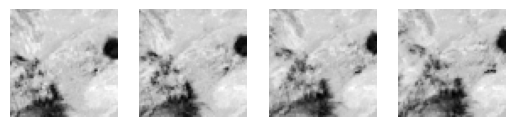

In [57]:
idx = 220

x0 = valid_ds[idx:idx+1].to(config.device)
print(x0.shape)
show_images(x0.squeeze())

In [16]:
preds = sample(model, x0[:,:-1,...])

In [17]:
last_frame = preds[-1]
last_frame.shape

torch.Size([1, 1, 64, 64])

<AxesSubplot: >

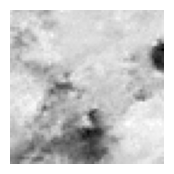

In [18]:
show_image(last_frame.squeeze())

Compare!

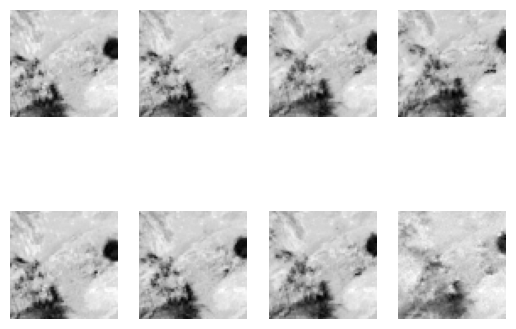

In [19]:
show_images(torch.cat([x0, x0[:,:-1], last_frame.to(x0.device)], dim=1).squeeze(), nrows=2)

In [20]:
x0[:,-3:,...].shape

torch.Size([1, 3, 64, 64])

In [21]:
def _sample_end(xt):
    "cut the array nd grabs last 3 frames"
    last_frame = sample(model, xt[:,-3:,...])[-1]
    return last_frame

In [23]:
def sample_more(xt, n=1):
    "Autoregressive sampling"
    frames = xt
    for _ in progress_bar(range(n), total=n):
        new_frame = _sample_end(frames)
        frames = torch.cat([frames, new_frame.to(xt.device)], dim=1)
    return frames

In [24]:
N = 5

In [25]:
frames = sample_more(x0, n=N)

Samples

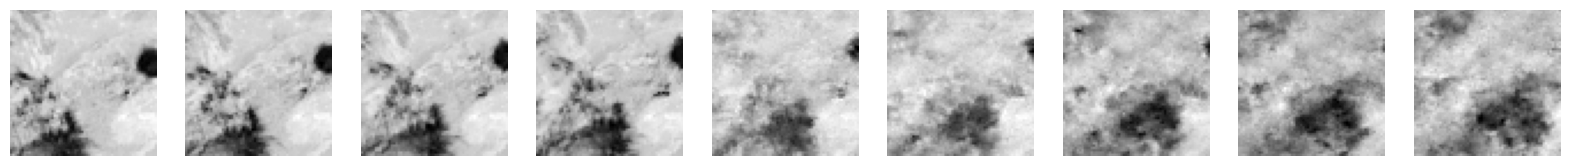

In [26]:
show_images(frames.squeeze(), figsize=(20,10))

GT

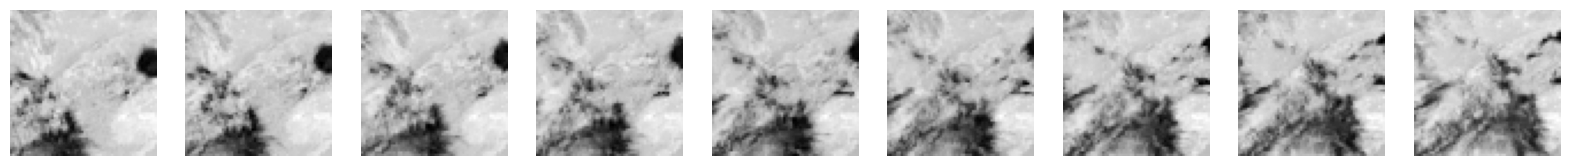

In [27]:
show_images(valid_ds[idx:idx+4+N,0,...], figsize=(20,10))

In [89]:
import numpy as np

def scale(arr):
    "Scales values of array in [0,1]"
    m, M = arr.min(), arr.max()
    return (arr - m) / (M - m)

def preprocess_frames(data):
    sdata = scale(data.squeeze())
    # print(sdata.shape)
    def tfm(frame):
        rframe = 255 * frame
        return rframe.cpu().numpy().astype(np.uint8)
    return [tfm(frame) for frame in sdata]

def to_video(data):
    "create wandb.Video container"
    frames = preprocess_frames(data)
    vid = np.stack(frames)[:, None, ...]
    return wandb.Video(vid)

## Log to wandb

In [90]:
N = 20

In [91]:
import random

k = 128

idxs = random.choices(range(len(valid_ds)), k=k)
x0 = valid_ds[idxs].to(config.device)

In [92]:
frames = sample_more(x0, N)

In [93]:
frames.shape

torch.Size([128, 24, 64, 64])

In [94]:
table = wandb.Table(columns=["id", "gt", "gen"])

In [95]:
for i, idx in enumerate(idxs):
    pred_vid = to_video(frames[i])
    gt_vid = to_video(valid_ds[idx:idx+4+N,0,...])
    table.add_data(idx, gt_vid, pred_vid)

In [96]:
with wandb.init(project="ddpm_clouds"):
    # wandb_vid = to_video(frames)
    # wandb.log({f"vid_{N}": wandb_vid})
    wandb.log({"gen_table_20":table})

In [ ]:
!sudo

In [58]:

idxs = [70, 200, 220]

pred_vids = []
gt_vids = []

for idx in idxs:
    print(f"Computing for idx: {idx}")
    x0 = valid_ds[idx:idx+1].to(config.device)
    frames = sample_more(x0, n=N)
    pred_vid = to_video(frames)
    pred_vids.append(pred_vid)
    
    # gt
    gt_vid = to_video(valid_ds[idx:idx+4+N,0,...])
    gt_vids.append(gt_vid)

Computing for idx: 70


torch.Size([14, 64, 64])
torch.Size([14, 64, 64])
Computing for idx: 200


torch.Size([14, 64, 64])
torch.Size([14, 64, 64])
Computing for idx: 220


torch.Size([14, 64, 64])
torch.Size([14, 64, 64])


In [61]:
with wandb.init(project="ddpm_clouds"):
    # wandb_vid = to_video(frames)
    # wandb.log({f"vid_{N}": wandb_vid})
    wandb.log({"gen_table":table})